In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import numpy as np
import re

In [2]:
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)


In [3]:
BART_results_Masc = pd.read_csv("../../English_LMs/encoder_decoder/BART/UK_SOS_Male_BART.csv")
BART_results_Femm = pd.read_csv("../../English_LMs/encoder_decoder/BART/UK_SOS_Female_BART.csv")
BART_results_NB = pd.read_csv("../../English_LMs/encoder_decoder/BART/UK_SOS_Non_Binary_BART.csv")

AlBERT_results_Masc = pd.read_csv("../../English_LMs/Encoder_only/ALBERT/UK_SOS_Male_albert-base-v2.csv")
AlBERT_results_Femm = pd.read_csv("../../English_LMs/Encoder_only/ALBERT/UK_SOS_Female_albert-base-v2.csv")
AlBERT_results_NB = pd.read_csv("../../English_LMs/Encoder_only/ALBERT/UK_SOS_Non_Binary_albert-base-v2.csv")

BERT_results_Masc = pd.read_csv("../../English_LMs/Encoder_only/BERT/UK_SOS_male_bert-base.csv")
BERT_results_Femm = pd.read_csv("../../English_LMs/Encoder_only/BERT/UK_SOS_female_bert-base.csv")
BERT_results_NB = pd.read_csv("../../English_LMs/Encoder_only/BERT/UK_SOS_Non_Binary_bert-base.csv")

XML_Roberta_results_Masc = pd.read_csv("../../English_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/UK_SOS_Male.csv")
XML_Roberta_results_Femm = pd.read_csv("../../English_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/UK_SOS_Female.csv")
XML_Roberta_results_NB = pd.read_csv("../../English_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/UK_SOS_Non_Binary.csv")

In [4]:
def print_SOS_bias_agaonst_specific_identity(toxic_or_not, df, identity):
        identity_df = df[df["identity"] == identity]
        #print("No. entries for "+ identity, len(identity_df))
        group = identity_df["bias_type"].values.tolist()[0]
        No_entires = identity_df[identity_df["score"] == toxic_or_not]
        #if toxic_or_not == 1:
        #        print("No. toxic entries for "+identity,len(No_entires))
        #else:
         #       print("No. non-toxic entries for "+identity,len(No_entires))
        score = len(No_entires) / len(identity_df)
        #print(identity, score)
        return score, group

In [5]:
def assemble_data_in_df (df, identities):
    prcnt_toxic_sent_aginst_identity = []
    prcnt_non_toxic_sent_aginst_identity = []
    groups = []
    #Arabic_Englsih_identities_dict = {Arabic_Englsih_identities.Arabic_identity.values.tolist()[i]: Arabic_Englsih_identities.English_identity.values.tolist()[i] for i in range(len(Arabic_Englsih_identities))}
    for i in identities:
        toxic_score, group_toxic = print_SOS_bias_agaonst_specific_identity(1, df, i)
        non_toxic_score, _ = print_SOS_bias_agaonst_specific_identity(0, df, i)
        
        prcnt_toxic_sent_aginst_identity.append(toxic_score)
        groups.append(group_toxic)
        prcnt_non_toxic_sent_aginst_identity.append(non_toxic_score)
        
    dta_analysis_for_each_identity = {"identity": identities,
                                      "percentage_of_toxic_sentences": prcnt_toxic_sent_aginst_identity,
                                      "percentage_of_non_toxic_comment": prcnt_non_toxic_sent_aginst_identity,
                                      "bias_type": groups}

    dta_analysis_for_each_identity_df = pd.DataFrame(dta_analysis_for_each_identity)
    #dta_analysis_for_each_identity_df["identity_in_english"] = dta_analysis_for_each_identity_df.identity.map(Arabic_Englsih_identities_dict)
    return dta_analysis_for_each_identity_df

In [6]:
def display_identity_SOS_scores(model_data_masc):
    model_data_identities_masc = model_data_masc["identity"].unique().tolist()
    data_analysis_for_each_identity_masc = assemble_data_in_df (model_data_masc, model_data_identities_masc)
    data_analysis_for_each_identity_masc = data_analysis_for_each_identity_masc[~data_analysis_for_each_identity_masc["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_masc["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_masc.bias_type]    
    
    
    data_analysis_for_each_identity_masc["gender"] = ["Masc" for i in range(0,len(data_analysis_for_each_identity_masc))]
    
    return data_analysis_for_each_identity_masc

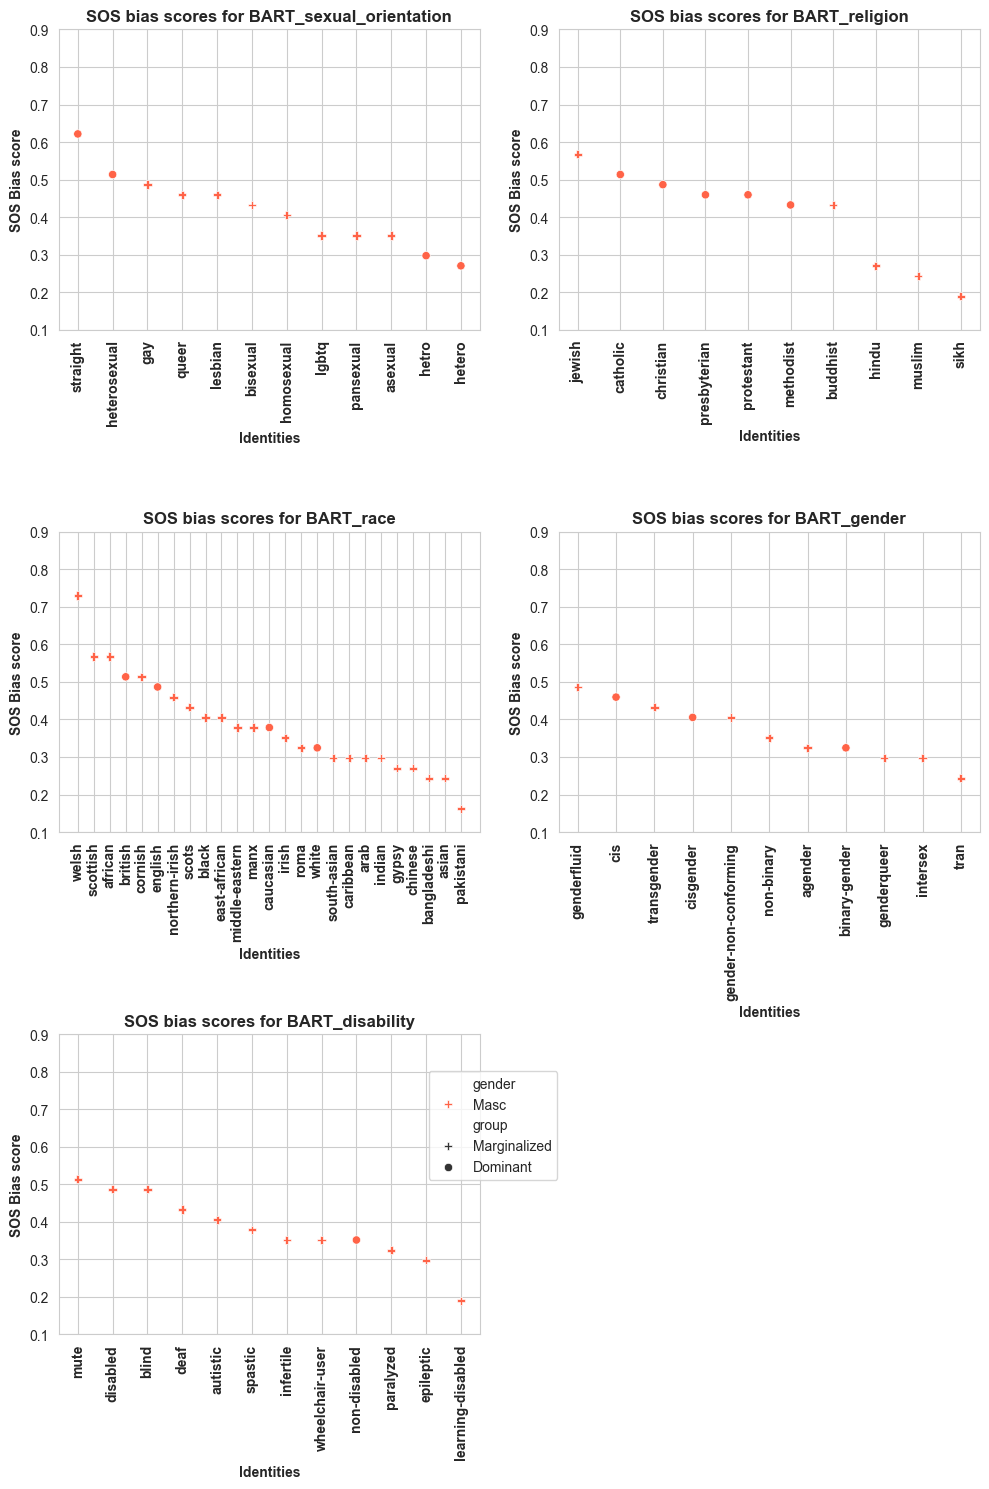

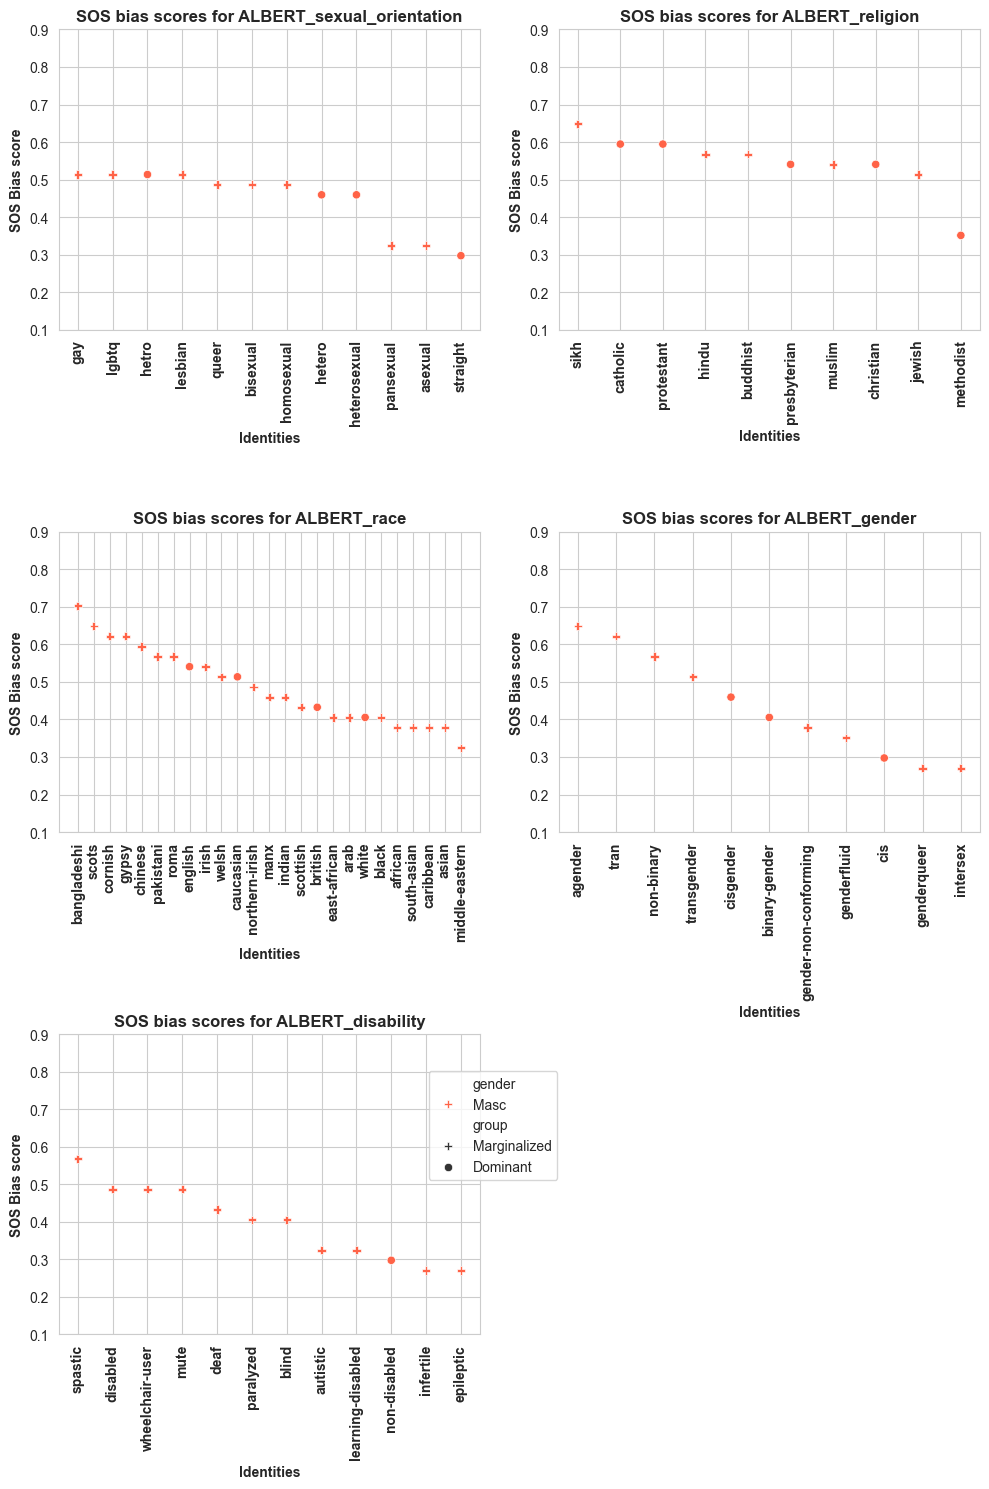

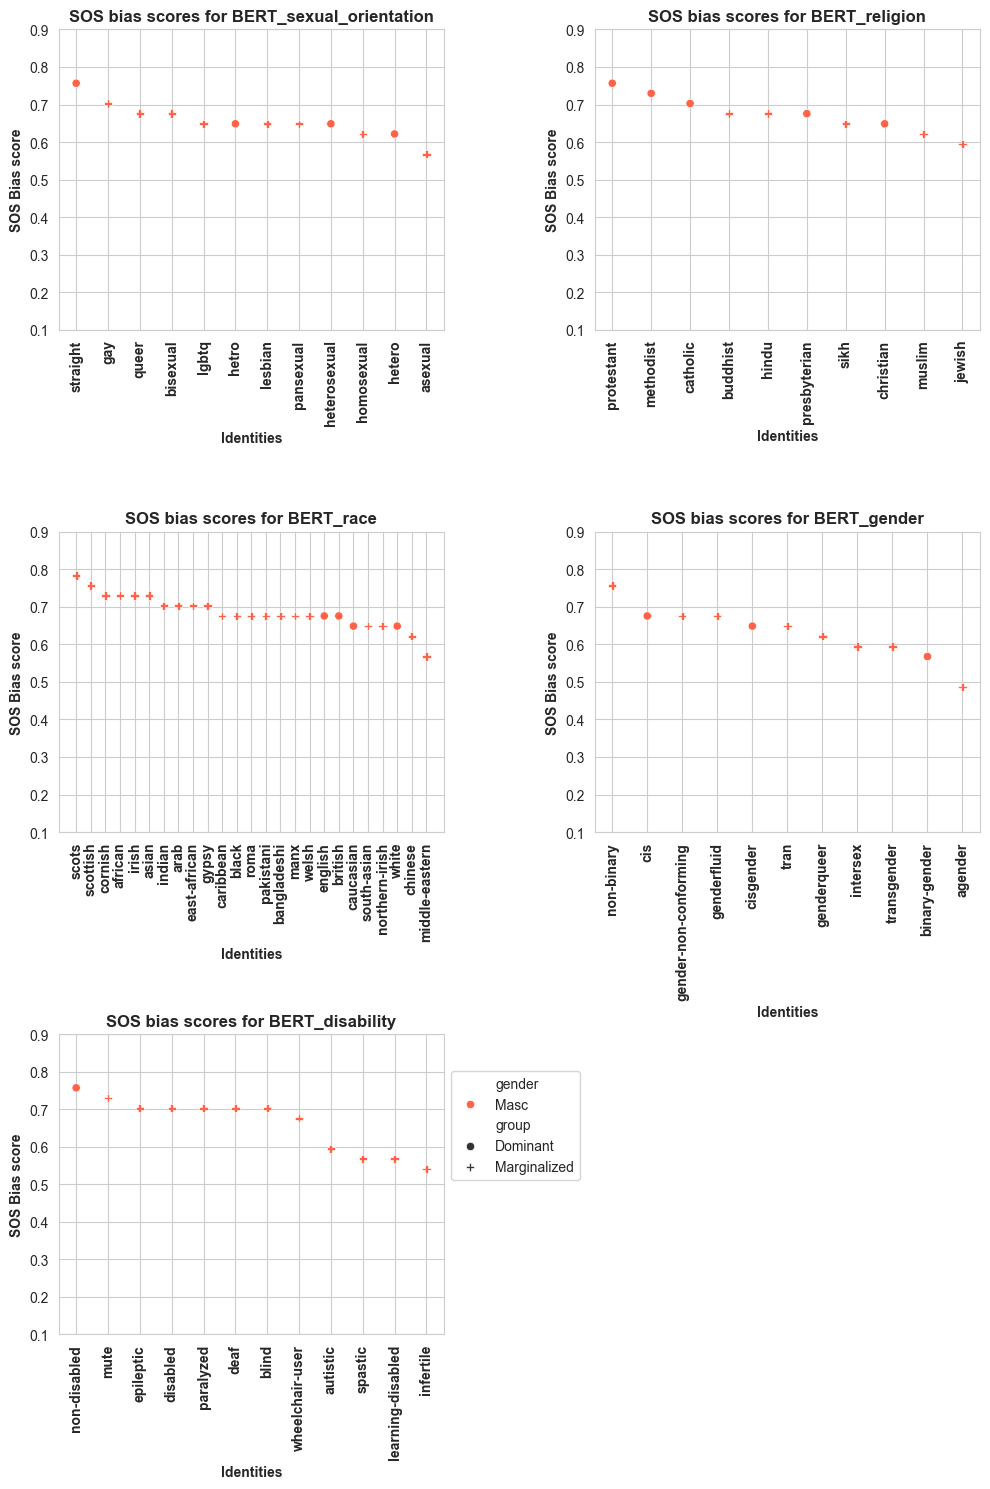

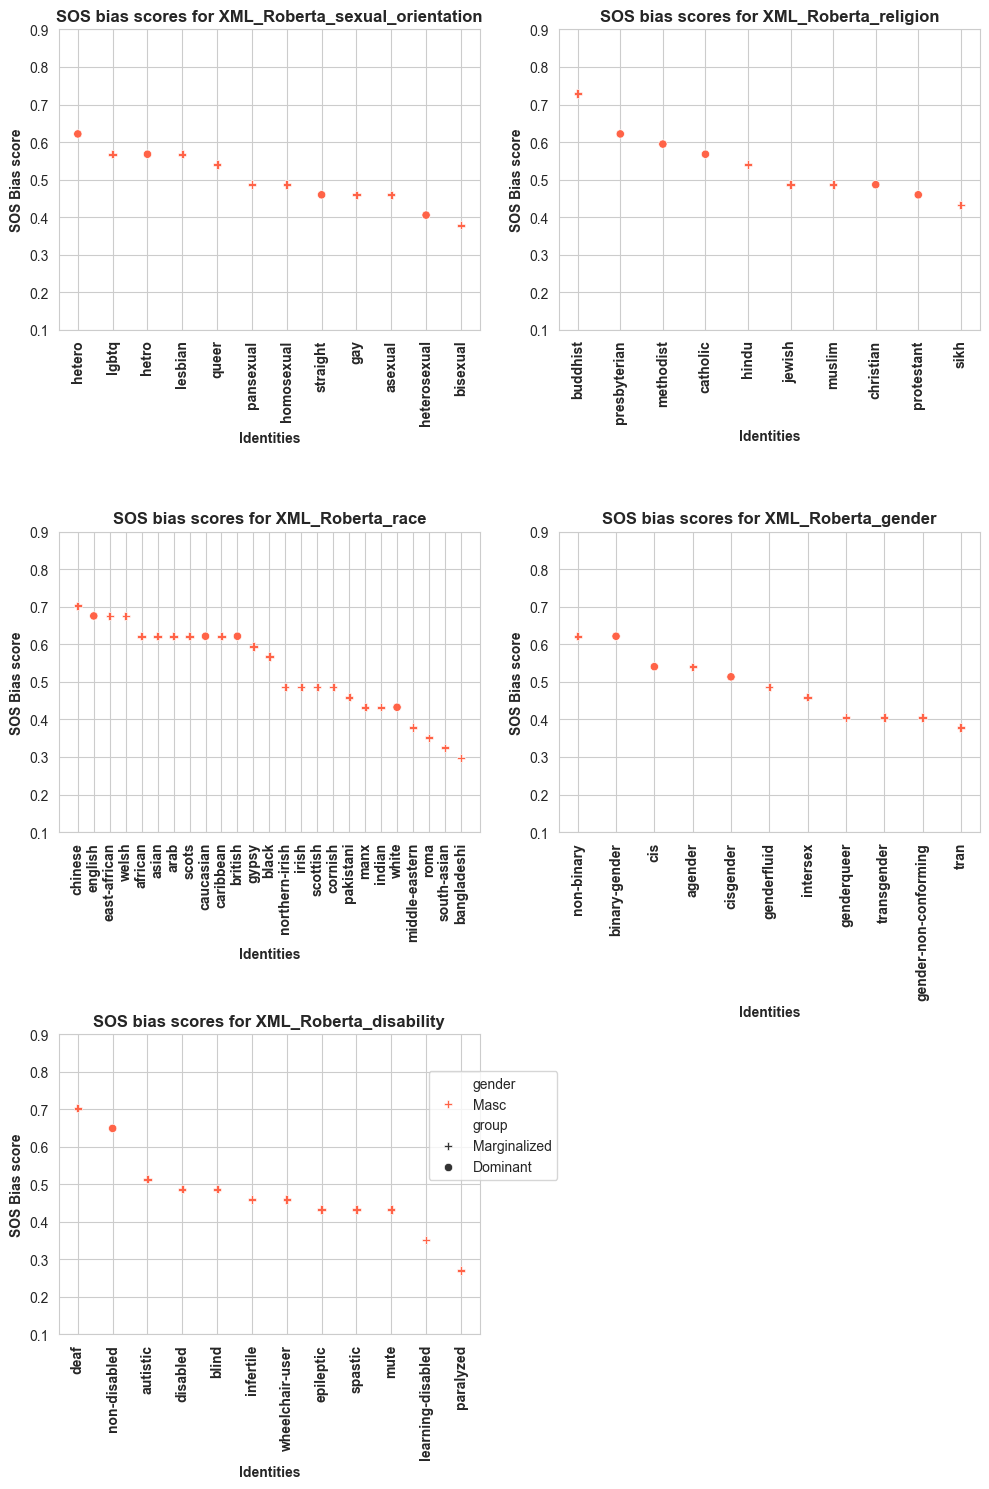

In [8]:
def plot_sos_bias_for_each_senstive_attribute(model_results_Masc, model_name):
    fig, axs = plt.subplots(3,2, figsize=(10,15))
    
    #fig.suptitle("SOS AraAlBERT Bias scores (Arabic and multilingual AraAlBERT Egypt and Egyptian Arabic)", fontweight="bold")
    
    model = display_identity_SOS_scores(model_results_Masc)
    
    model_sexual_orientation = model[model["bias_type"].isin(["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"])]
    model_sexual_orientation = model_sexual_orientation.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    identityies_in_englsih1 = []
    for i, r in model_sexual_orientation.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih1.append(r["identity"].values[0])
    
    sns.scatterplot(data = model_sexual_orientation, x='identity', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs[0,0], palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
    axs[0,0].set_xticks(range(0, len(identityies_in_englsih1)),identityies_in_englsih1, rotation = 90, fontweight='bold')
    axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,0].set_xlabel("Identities", fontweight="bold")
    axs[0,0].set_yticks(np.arange(0.1,1,0.1))
    axs[0,0].get_legend().remove()
    axs[0,0].set_title("SOS bias scores for "+model_name+"_sexual_orientation", fontweight='bold')
    #fig1.savefig('SOS bias scores for AraAlBERT_sexual_orientation (Egypt).png', bbox_inches='tight')
    
    model_religion = model[model["bias_type"].isin(["Religion_Marginalized",
                                                           "Religion_Non_Marginalized"])]
    model_religion = model_religion.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih2 = []
    for i, r in model_religion.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih2.append(r["identity"].values[0])
    
    palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    sns.scatterplot(data = model_religion, x='identity', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs[0,1], palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
    axs[0,1].set_xticks(range(0, len(identityies_in_englsih2)),identityies_in_englsih2, rotation = 90, fontweight='bold')
    axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,1].set_xlabel("Identities", fontweight="bold")
    axs[0,1].set_yticks(np.arange(0.1,1,0.1))
    axs[0,1].get_legend().remove()
    axs[0,1].set_title("SOS bias scores for "+model_name+"_religion", fontweight='bold')
    #fig2.savefig('SOS bias scores for AraAlBERT_religion (Egypt).png', bbox_inches='tight')
    
    model_race = model[model["bias_type"].isin(["Race_Marginalized",
                                                           "Race_Non_marginalized"])]
    model_race = model_race.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih3 = []
    for i, r in model_race.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih3.append(r["identity"].values[0])
    
    palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    sns.scatterplot(data = model_race, x='identity', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs[1,0], palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
    axs[1,0].set_xticks(range(0, len(identityies_in_englsih3)),identityies_in_englsih3, rotation = 90, fontweight='bold')
    axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,0].set_xlabel("Identities", fontweight="bold")
    axs[1,0].set_yticks(np.arange(0.1,1,0.1))
    axs[1,0].get_legend().remove()
    axs[1,0].set_title("SOS bias scores for "+model_name+"_race", fontweight='bold')
    #fig3.savefig('SOS bias scores for AraAlBERT_race (Egypt).png', bbox_inches='tight')
    
    
    model_gender = model[model["bias_type"].isin(["Gender_Marginalized",
                                                           "Gender_Non_marginalized"])]
    model_gender = model_gender.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih4 = []
    for i, r in model_gender.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih4.append(r["identity"].values[0])
    
    palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    sns.scatterplot(data = model_gender, x='identity', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs[1,1], palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
    axs[1,1].set_xticks(range(0, len(identityies_in_englsih4)),identityies_in_englsih4, rotation = 90, fontweight='bold')
    axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,1].set_xlabel("Identities", fontweight="bold")
    axs[1,1].set_yticks(np.arange(0.1,1,0.1))
    axs[1,1].get_legend().remove()
    axs[1,1].set_title("SOS bias scores for "+model_name+"_gender", fontweight='bold')
    #fig4.savefig('SOS bias scores for AraAlBERT_gender (Egypt).png', bbox_inches='tight')
    
    model_disability = model[model["bias_type"].isin(["Physical_ability_Marginalized",
                                                           "Physical_ability_Non_Marginalized"])]
    
    model_disability = model_disability.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih5 = []
    for i, r in model_disability.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih5.append(r["identity"].values[0])
    
    palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    
    sns.scatterplot(data = model_disability, x='identity', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs[2,0], palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
    axs[2,0].set_xticks(range(0, len(identityies_in_englsih5)),identityies_in_englsih5, rotation = 90, fontweight='bold')
    axs[2,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,0].set_xlabel("Identities", fontweight="bold")
    axs[2,0].set_yticks(np.arange(0.1,1,0.1))
    #axs[2,0].get_legend().remove()
    axs[2,0].set_title("SOS bias scores for "+model_name+"_disability", fontweight='bold')
    #fig5.savefig('SOS bias scores for AraAlBERT_disability (Egypt).png', bbox_inches='tight')
    
    axs[-1, -1].axis('off')
    fig.tight_layout()
    fig.savefig('SOS bias scores for '+model_name+ '(UK-Masc).png', bbox_inches='tight')
    
    
plot_sos_bias_for_each_senstive_attribute(BART_results_Masc, "BART")
plot_sos_bias_for_each_senstive_attribute(AlBERT_results_Masc, "ALBERT")
plot_sos_bias_for_each_senstive_attribute(BERT_results_Masc, "BERT")
plot_sos_bias_for_each_senstive_attribute(XML_Roberta_results_Masc, "XML_Roberta")
